In [19]:
import numpy as np
import torch
import torch.optim
import torch.nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [20]:
imsize = 224

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [21]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

In [22]:
content_img = image_loader("images/cat.jpg")
style_img = image_loader("images/monet.jpg")

In [23]:
unloader = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
    transforms.ToPILImage()])

In [24]:
def tensor2image(tensor):
    image = tensor.clone() 
    image = image.squeeze(0)  
    image = unloader(image)
    return image

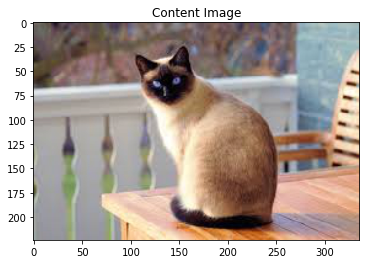

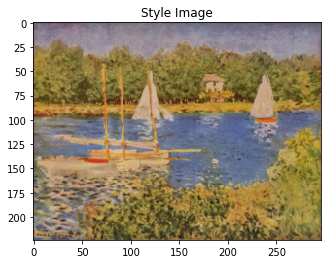

In [25]:
plt.figure()
plt.imshow(tensor2image(content_img))
plt.title("Content Image")
plt.show()

plt.figure()
plt.imshow(tensor2image(style_img))
plt.title("Style Image")
plt.show()

In [26]:
    vgg = models.vgg19(pretrained=True).features

    for param in vgg.parameters():
        param.requires_grad_(False)

In [27]:
def get_features(x, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    for name, layer in model._modules.items():
        if name in layers:
            x = layer(x)
            features[layers[name]] = x
            
    return features

In [ ]:
def gram_matrix(tensor):

    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [ ]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [ ]:
target_img = content_img.clone().requires_grad_(True)

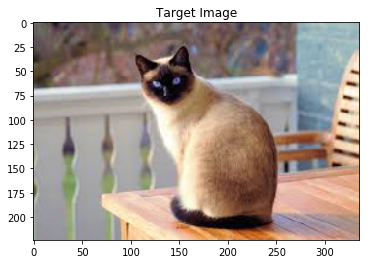

In [ ]:
plt.figure()
plt.imshow(tensor2image(target_img))
plt.title("Target Image")
plt.show()

In [ ]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [ ]:
alpha = 1
beta = 1e6

In [ ]:
show_every = 500

optimizer = torch.optim.Adam([target_img], lr=0.003)
steps = 6000

Total loss:  334985840033792.0


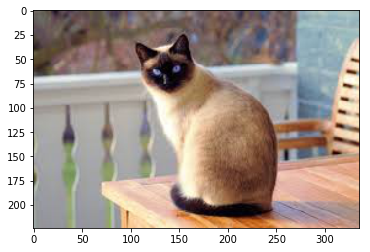

In [ ]:
for i in range(1, steps+1):
    
    target_features = get_features(target_img, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    

    style_loss = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = alpha * content_loss + beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  i % show_every == 0 or i == 1:
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor2image(target_img))
        plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor2image(content_img))
ax2.imshow(tensor2image(target_img))
plt.show()